# CORD-19 NLP Workflow

## Dataset Overview

The CORD-19 dataset [url](https://www.semanticscholar.org/cord19) is an open dataset curated by the Allen Institute for AI intended to facilitate NLP research efforts pertaining to COVID-19. It provides a compilation of relevant peer-reviewed research publications from queries to the following sources: 

- PubMed's open access corpus
- The WHO's open access corpus
- bioRxiv and medRxiv preprints

The CORD-19 dataset is updated daily, with a .csv of publication metadata provided as well as full text (as available) from articles in JSON format. This dataset is part of a number of NLP research efforts, and is a current Kaggle challenge dataset [url](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge).

## Workflow Overview

Our goal is to provide a workflow for automating data preparation, processing, and resources for analyses of this dataset. We chose this dataset in part due to its timeliness and relevance, as well as its recurring updates; indeed, it lends itself well to automation. Having a workflow of this sort also foments experiment repeatability and provenance, two crucial elements in accountable AI. 

With this in mind, we provide below our means for:

- Acquiring the dataset
- Preparing and processing the data of interest
- Generating summary information 

We chose to focus on the abstract details in the metadata.csv file provided by CORD-19 and the associated full text provided in the pdf_json directory. The former file provides full abstracts from publications, while the latter files provide complete text, both of which we utilize for unsupervised topic modeling via LDA.

First we'll import our libraries. We'll use spacy for extracting tokens from the abstracts, nltk for its stopwords corpus as we found it to be more comprehensive than spacy's, gensim to generate a corpus and LDA model, and plotting libraries for visualizing summaries.  


In [1]:
import csv
import os
import json
from collections import defaultdict
import tqdm
from itertools import islice

import numpy as np
import pandas as pd

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
spacy.prefer_gpu()

from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_lg 

from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

import nltk
from nltk.corpus import stopwords 
import pyLDAvis.gensim

We'll first acquire the dataset and extract it. 

In [2]:
abstract_only = False

dataset_date='2020-07-16'
dataset_url_prefix = 'https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/'

if abstract_only == True:
    dataset_filename = 'metadata.csv'
    dataset_url = dataset_url_prefix + dataset_date + '/' + dataset_filename
    !wget "$dataset_url"
else:
    dataset_filename = 'cord-19_' + dataset_date + '.tar.gz'
    dataset_url = dataset_url_prefix + 'historical_releases/' + dataset_filename
    if os.path.exists(dataset_date) != True:
        !wget -nc "$dataset_url"
        !tar -xzf "$dataset_filename"
        os.chdir(dataset_date)
        !tar -xzf document_parses.tar.gz
    else:
        os.chdir(dataset_date)

--2020-07-31 11:15:10--  https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases/cord-19_2020-07-16.tar.gz
Resolving ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com (ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com)... 52.218.241.65
Connecting to ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com (ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com)|52.218.241.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3662861028 (3.4G) [binary/octet-stream]
Saving to: ‘cord-19_2020-07-16.tar.gz’

cord-19_2020-07-16. 100%[===================>]   3.41G  9.55MB/s    in 4m 40s  

2020-07-31 11:19:50 (12.5 MB/s) - ‘cord-19_2020-07-16.tar.gz’ saved [3662861028/3662861028]



Next we'll load spacy, and add our own set of words to the NLTK stopwords set, then update spacy's default stop_words set. By doing this, we reduce the potential for generally unique but dataset specific uninteresting and expected words to appear in our topic lists.

In [3]:
nlp= spacy.load("en_core_web_lg")
stop_words = stopwords.words('english')
stop_words.extend(['sars','covid-19', 'cov-2','=','from', 'subject', 're', 'edu', 'use', 'not', 
                   'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 
                   'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 
                   'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 
                   'line', 'even', 'also', 'may', 'take', 'come'])

nlp.Defaults.stop_words.update(stop_words)

Much like we are looking to automate this work on a macro level, we're also fans of the pipeline infrastructure spacy provides, so we define two steps of our NLP pipeline below and add them to our spacy instance. Namely, preprocessing the text provided by splitting into tokens and removing punctuation, stop words, and numerics. 

In [4]:
def lemmatize(doc):
    doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    doc = u' '.join(doc)
    return nlp.make_doc(doc)
    
def clean_tokens(doc):
    doc = [token.text for token in doc if token.is_stop != True and token.is_punct != True and (len(token)<=4)!=True]
    return doc

In [5]:
nlp.add_pipe(lemmatize,name='lemmatize',after='ner')
nlp.add_pipe(clean_tokens, name="cleanup", last=True)

Now we're ready to extract our abstract and publication data from metadata.csv, as well as the full text from the json-ified publication files. We then process each extracted piece of data through our spacy pipeline, then add it to a running list of abstracts and full text. For purposes of resource reduction and speed, the `dataset_limit` variable is provided below. This can be modified to process the entire dataset accordingly. 

In [6]:
fulltext_list = []
abstract_list = []
nlp.max_length = 2000000
dataset_limit = 100

with open('metadata.csv') as f_in:
    reader = csv.DictReader(f_in)
    for row in tqdm.tqdm_notebook(islice(reader, 0, dataset_limit),total=dataset_limit):
        if row['abstract']:
            abstract = row['abstract']
            nlp_abstract = nlp(abstract)
            abstract_list.append(nlp_abstract)
        if abstract_only == False:
            all_text = []
            if row['pdf_json_files']:
                for json_path in row['pdf_json_files'].split('; '):
                    with open(json_path) as f_json:
                        full_text_dict = json.load(f_json)
                        for paragraph_dict in full_text_dict['body_text']:
                            paragraph_text = paragraph_dict['text']
                            section_name = paragraph_dict['section']
                            all_text.append(paragraph_text)
                nlp_fulltext = nlp(u' '.join(all_text))
                fulltext_list.append(nlp_fulltext)                                

/Users/jason/.virtualenvs/dataprep/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


With our document lists in place, we are ready to generated our word dictionary and corpus for abstracts and full text, which we then can use to (finally) create an LDA model of our documents!

In [7]:
def generate_corpus(doc_list):
    words=corpora.Dictionary(doc_list)
    corpus = [words.doc2bow(doc) for doc in doc_list]
    return [words,corpus]

def generate_lda_model(words,corpus):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=words,
                                            num_topics=10, 
                                            random_state=2,
                                            update_every=1,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)  
    return lda_model

In [8]:
gen_corp = generate_corpus(abstract_list)
abstract_words=gen_corp[0]
abstract_corpus=gen_corp[1]
abstract_lda_model = generate_lda_model(abstract_words,abstract_corpus)

In [9]:
gen_corp = generate_corpus(fulltext_list)
fulltext_words=gen_corp[0]
fulltext_corpus=gen_corp[1]
fulltext_lda_model = generate_lda_model(fulltext_words,fulltext_corpus)

As we now have LDA models generated, we can visualize our analyses. Below we generate word clouds for our topics. Followed by a pyLDAvis gensim specific topic modeling plot showing word strength within topics and distance between topic clusters.

In [10]:
def plotWordcloud(lda_model,stop_words):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    cloud = WordCloud(stopwords=stop_words,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

    topics = lda_model.show_topics(formatted=False)

    fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')


    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    return plt

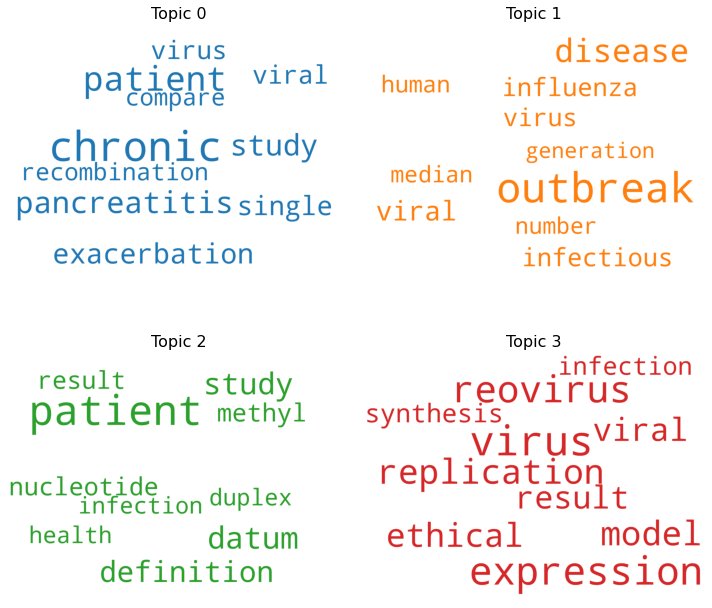

In [11]:
abstract_wordcloud = plotWordcloud(abstract_lda_model, stop_words)

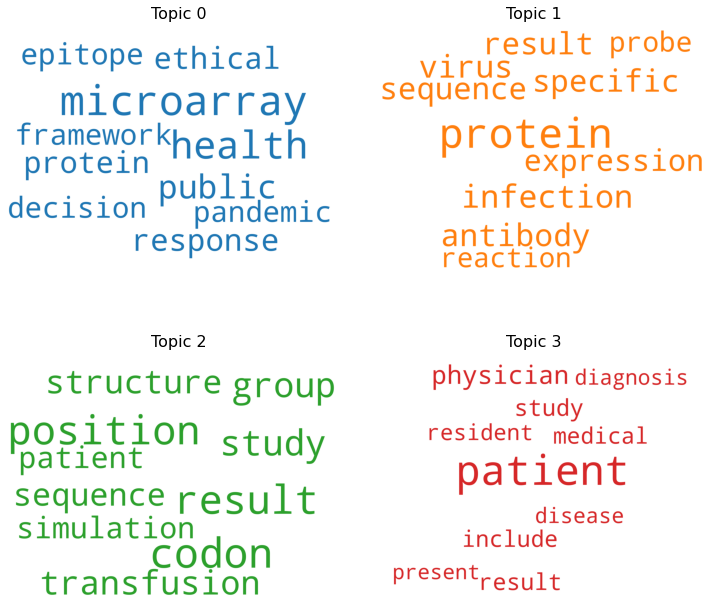

In [12]:
fulltext_wordcloud = plotWordcloud(fulltext_lda_model, stop_words)

In [13]:
pyLDAvis.enable_notebook()                           

In [14]:
abstract_ldavis = pyLDAvis.gensim.prepare(abstract_lda_model, abstract_corpus, dictionary=abstract_lda_model.id2word)
abstract_ldavis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.014937 -0.016412       1        1  14.578512
3     -0.068447  0.083803       2        1  12.299321
5     -0.125926  0.000697       3        1  11.909030
1      0.070029 -0.037462       4        1   9.659078
0      0.078375  0.134554       5        1   9.575462
8     -0.030805 -0.041702       6        1   9.248757
4     -0.055304  0.068154       7        1   8.761241
2      0.149135  0.020359       8        1   8.212414
7      0.041964 -0.142254       9        1   7.984310
9     -0.044086 -0.069737      10        1   7.771873, topic_info=              Term       Freq      Total Category  logprob  loglift
468       outbreak  27.000000  27.000000  Default  30.0000  30.0000
49         patient  42.000000  42.000000  Default  29.0000  29.0000
206        chronic  22.000000  22.000000  Default  28.0000  28.0000
931     microarray  24.000000  24.000000  Default  27.0000  27.0000
122        protein  50.000000  50.000000  Default  26.0000  26.0000
...            ...        ...        ...      ...      ...      ...
277         genome   3.521878  22.091549  Topic10  -5.2887   0.7185
1688  preparedness   2.955301  11.761612  Topic10  -5.4641   1.1734
79        activity   2.949737  12.360593  Topic10  -5.4659   1.1219
189       response   3.044745  20.813341  Topic10  -5.4342   0.6325
299        suggest   2.944559  19.905760  Topic10  -5.4677   0.6436

[621 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
649       7  0.890280  10(-3)/min
1735      8  0.892698   3-gallate
2422      1  0.736540     Alberta
1858      4  0.868270     America
2161      3  0.849661     Archaea
...     ...       ...         ...
306       2  0.239682       yield
306       4  0.119841       yield
306       6  0.119841       yield
306       7  0.479363       yield
306       8  0.119841       yield

[1253 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 6, 2, 1, 9, 5, 3, 8, 10])

In [15]:
fulltext_ldavis = pyLDAvis.gensim.prepare(fulltext_lda_model, fulltext_corpus, dictionary=fulltext_lda_model.id2word)
fulltext_ldavis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.142488 -0.143717       1        1  52.344429
1     -0.099724  0.021469       2        1   9.523789
4      0.071028  0.083889       3        1   7.389720
6     -0.142181 -0.024258       4        1   7.274082
5     -0.024074 -0.053589       5        1   5.445249
9      0.061908  0.095774       6        1   5.060582
0      0.094693  0.093009       7        1   4.133090
7     -0.094973  0.029883       8        1   3.424319
8      0.021397 -0.059825       9        1   3.008688
2     -0.030563 -0.042634      10        1   2.396048, topic_info=          Term         Freq        Total Category  logprob  loglift
1631    health  1265.000000  1265.000000  Default  30.0000  30.0000
281    patient  5089.000000  5089.000000  Default  29.0000  29.0000
800    protein  1062.000000  1062.000000  Default  28.0000  28.0000
127    contact   499.000000   499.000000  Default  27.0000  27.0000
1428  sequence   894.000000   894.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
281    patient    35.683655  5089.196289  Topic10  -5.4015  -1.2288
635   indicate    23.737135   405.893921  Topic10  -5.8091   0.8923
505    contain    23.137108   398.247040  Topic10  -5.8347   0.8857
633   increase    23.151712  1080.749023  Topic10  -5.8341  -0.1120
241     method    21.922699   571.552856  Topic10  -5.8886   0.4705

[764 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
7852       8  0.941357   -portion
5049       3  0.841531      10000
6857       8  0.919492    28s:18s
7585      10  0.880459    5ј-half
5256       5  0.955496     8-oxog
...      ...       ...        ...
5246       7  0.041302  workplace
7951       8  0.855308     wtRNA2
7952       8  0.964843     wtrna1
4671       5  0.934089     Èttger
20846      9  0.745591     ðencap

[2509 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 5, 7, 6, 10, 1, 8, 9, 3])

Next we'll move relevant pieces of this code to containerized applciations contained within OpenShift, which will then be orchestrated with an Argo workflow.